In [1]:
import os
from datetime import datetime, timedelta, timezone
from skyfield.api import load, Topos, EarthSatellite
import matplotlib.pyplot as plt
from model.distribution_efficiency_stat2sat import communication_loss_stat2sat_coordinate
import numpy as np

# all satellite TLE directory
directory = 'TLE_data/'
output_file = "Starlink_TLE/TLE_history.txt"


In [2]:
def parse_tle_epoch(epoch):
    year = int(epoch[:2])
    if year < 57:
        year += 2000
    else:
        year += 1900
    day_of_year = float(epoch[2:])
    day = int(day_of_year)
    fractional_day = day_of_year - day
    date = datetime(year, 1, 1, tzinfo=timezone.utc) + timedelta(days=day - 1)
    time_of_day = timedelta(days=fractional_day)
    return date + time_of_day



# checj if TLE in the time range
def is_tle_in_date_range(tle, start_date, end_date):
    epoch = tle.split()[3]
    tle_time = parse_tle_epoch(epoch)
    return start_date <= tle_time <= end_date

In [3]:
def get_latest_tle(tle_list, target_time):
    latest_tle = None
    latest_time = None
    for tle in tle_list:
        epoch = tle.split()[4]
        #print(epoch)
        tle_time = parse_tle_epoch(epoch)
        if tle_time <= target_time:
            if latest_time is None or tle_time > latest_time:
                latest_tle = tle
                latest_time = tle_time
    return latest_tle

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

In [6]:
# load tle data and order by time
document_file = 'Starlink_TLE/Single_Satellite_TLE'
satellite_name = 'STARLINK-1094'
tle_file = os.path.join(document_file, f'{satellite_name}.txt')
tle_data = []

with open(tle_file, 'r') as file:
    lines = file.readlines()
    i = 0
    while i < len(lines):
        if lines[i].startswith(satellite_name):
            tle1 = lines[i+1].strip()
            tle2 = lines[i+2].strip()
            tle_epoch = parse_tle_epoch(tle1.split()[3])
            tle_data.append((tle_epoch, tle1, tle2))
            
            i += 3
        else:
            i += 1

tle_data.sort(key=lambda x: x[0])  # 按历元时间排序d

In [7]:
# gemerate time series
start_time = datetime(2023, 12, 31, 23, 0, 0, tzinfo=timezone.utc)
end_time = datetime(2024, 1, 1, 2, 0, 0, tzinfo=timezone.utc)
time_step = timedelta(minutes = 0.5)
time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step + 1)]

In [8]:
start_time = datetime(2024, 1, 1, 0, 0, 0, tzinfo=timezone.utc)
end_time = datetime(2024, 1, 1, 0, 5, 0, tzinfo=timezone.utc)
time_step = timedelta(seconds = 1)
time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step + 1)]


In [61]:

specific_time = datetime(2024, 1, 1, 0, 0, 0,  tzinfo=timezone.utc)
start_time = specific_time + timedelta(minutes = -4.5)
end_time = specific_time+timedelta(minutes = 5)
time_step = timedelta(seconds = 1)
time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step )]


In [62]:
# Define the ground stations with coordinates and continent
ground_stations = {
    "New York": {"latitude": 40.7128, "longitude": -74.0060, "continent": "North America"},
    "Washington D.C.": {"latitude": 38.9072, "longitude": -77.0369, "continent": "North America"},
}

# Calculate etas for both New York and Washington D.C.
station1 = ground_stations["New York"]
station2 = ground_stations["Washington D.C."]

# Initialize lists for etas
etas_new_york = []
etas_washington_dc = []
tle_index = 0
ts = load.timescale()
etas = []

for current_time in time_series:
    # 更新TLE数据
    while tle_index < len(tle_data) - 1 and tle_data[tle_index + 1][0] <= current_time:
        tle_index += 1

    latest_tle = tle_data[tle_index]
    # 计算海拔
    satellite = EarthSatellite(latest_tle[1], latest_tle[2], satellite_name, ts)

    current_time_ts = ts.utc(current_time.year, current_time.month, current_time.day, current_time.hour, current_time.minute, current_time.second)
    geocentric = satellite.at(current_time_ts)
    subpoint = geocentric.subpoint()

    satellite_altitude = subpoint.elevation.km
    satellite_latitude = subpoint.latitude.degrees
    satellite_longitude = subpoint.longitude.degrees

    # Calculate etas for New York
    eta_ny = communication_loss_stat2sat_coordinate(
        station1['latitude'], station1['longitude'], 0,
        satellite_latitude, satellite_longitude, satellite_altitude)
    etas_new_york.append(eta_ny)

    # Calculate etas for Washington D.C.
    eta_dc = communication_loss_stat2sat_coordinate(
        station2['latitude'], station2['longitude'], 0,
        satellite_latitude, satellite_longitude, satellite_altitude)
    etas_washington_dc.append(eta_dc)
    etas.append(eta_ny*eta_dc)
    

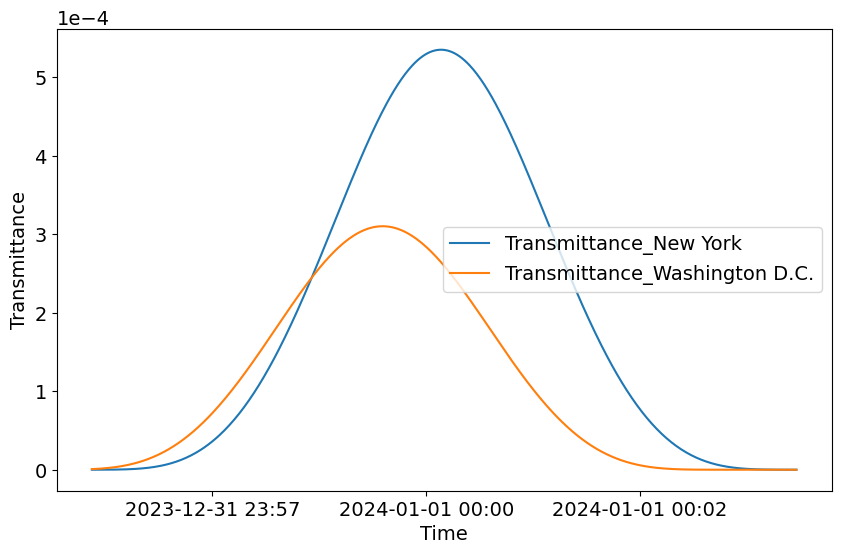

In [79]:
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates


# Increase font sizes for all text in the plot
plt.rcParams.update({'font.size': 14})  # Update font size globally
# 绘制效率随时间变化的图
plt.figure(figsize=(10, 6))
plt.plot(time_series, etas_new_york, label='Transmittance_New York')
plt.plot(time_series, etas_washington_dc, label='Transmittance_Washington D.C.')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Transmittance')
#plt.title('link efficiency between New York and Los Angeles')
plt.grid(False)
#plt.yscale('log')
# Set x-axis ticks to show a maximum of 6 labels
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=4))

# Set y-axis to scientific notation
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

#Formatting the x-axis to show date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))



plt.show()

In [60]:

specific_time = datetime(2024, 1, 1, 0, 0, 0,  tzinfo=timezone.utc)
start_time = specific_time + timedelta(minutes = -5)
end_time = specific_time+timedelta(minutes = 4)
time_step = timedelta(seconds = 1)
time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step )]


In [42]:
# Define the ground stations with coordinates and continent
ground_stations = {
    "New York": {"latitude": 40.7128, "longitude": -74.0060, "continent": "North America"},
    "Washington D.C.": {"latitude": 38.9072, "longitude": -77.0369, "continent": "North America"},
}

# Calculate etas for both New York and Washington D.C.
station1 = ground_stations["New York"]
station2 = ground_stations["Washington D.C."]

# Initialize lists for etas
etas_new_york = []
etas_washington_dc = []
tle_index = 0
ts = load.timescale()
etas = []

for current_time in time_series:
    # 更新TLE数据
    while tle_index < len(tle_data) - 1 and tle_data[tle_index + 1][0] <= current_time:
        tle_index += 1

    latest_tle = tle_data[tle_index]
    # 计算海拔
    satellite = EarthSatellite(latest_tle[1], latest_tle[2], satellite_name, ts)

    current_time_ts = ts.utc(current_time.year, current_time.month, current_time.day, current_time.hour, current_time.minute, current_time.second)
    geocentric = satellite.at(current_time_ts)
    subpoint = geocentric.subpoint()

    satellite_altitude = subpoint.elevation.km
    satellite_latitude = subpoint.latitude.degrees
    satellite_longitude = subpoint.longitude.degrees

    # Calculate etas for New York
    eta_ny = communication_loss_stat2sat_coordinate(
        station1['latitude'], station1['longitude'], 0,
        satellite_latitude, satellite_longitude, satellite_altitude)
    etas_new_york.append(eta_ny)

    # Calculate etas for Washington D.C.
    eta_dc = communication_loss_stat2sat_coordinate(
        station2['latitude'], station2['longitude'], 0,
        satellite_latitude, satellite_longitude, satellite_altitude)
    etas_washington_dc.append(eta_dc)
    etas.append(eta_ny*eta_dc)
    

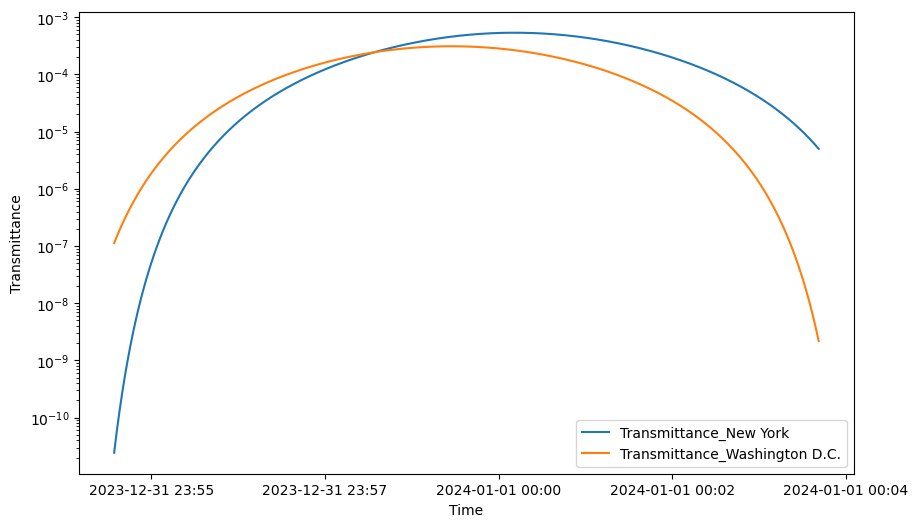

In [43]:
# Filtering out points where the efficiency is less than 1e-11
threshold = 1e-7
# Filtering out points where the efficiency is less than 1e-11 for both cities
filtered_time_series, filtered_etas_new_york, filtered_etas_washington_dc = [], [], []

for time, eta_ny, eta_dc in zip(time_series, etas_new_york, etas_washington_dc):
    if eta_ny >= threshold or eta_dc >= threshold:
        filtered_time_series.append(time)
        filtered_etas_new_york.append(eta_ny)
        filtered_etas_washington_dc.append(eta_dc)
        
# Plotting efficiency over time with log scale for the y-axis after filtering
plt.figure(figsize=(10, 6))
plt.plot(filtered_time_series, filtered_etas_new_york, label='Transmittance_New York')
plt.plot(filtered_time_series, filtered_etas_washington_dc, label='Transmittance_Washington D.C.')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Transmittance')
plt.yscale('log')
plt.grid(False)

# Set x-axis ticks to show a maximum of 5 labels
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))

# Set y-axis to scientific notation
#plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

# Formatting the x-axis to show date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.show()


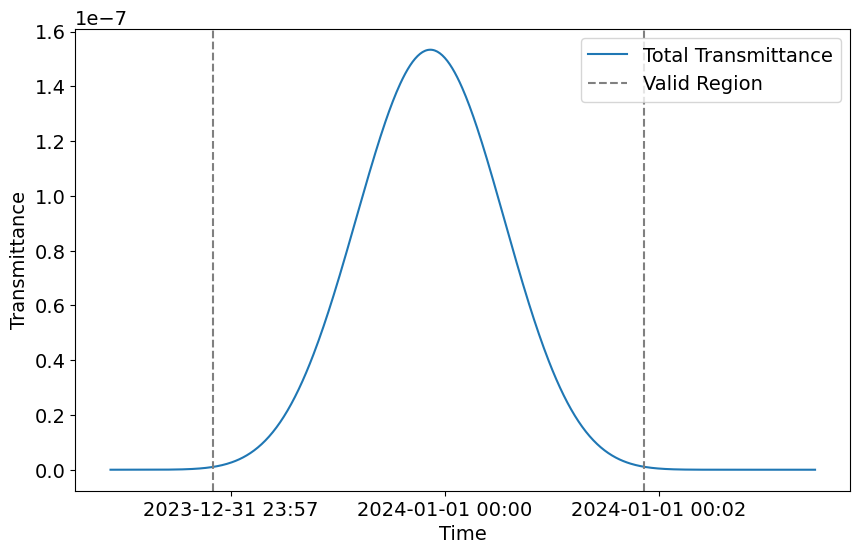

In [78]:
# Increase font sizes for all text in the plot
plt.rcParams.update({'font.size': 14})  # Update font size globally
# Plotting a new graph with vertical dashed lines for etas > 1e9
plt.figure(figsize=(10, 6))
plt.plot(time_series, etas, label='Total Transmittance')


# Identifying the range where eta >= 1e-9 and shading it
eta_threshold = 1e-9
indices_above_threshold = np.where(np.array(etas) >= eta_threshold)[0]
if len(indices_above_threshold) > 0:
    start_index = indices_above_threshold[0]
    end_index = indices_above_threshold[-1]
    #plt.axvline(time_series[start_index], color='grey', linestyle='--', label='Valid Region Start')
    #plt.axvline(time_series[end_index], color='grey', linestyle='--', label='Valid Region End')

    plt.axvline(time_series[start_index], color='grey', linestyle='--', label='Valid Region')
    plt.axvline(time_series[end_index], color='grey', linestyle='--')



plt.legend()
plt.xlabel('Time')
plt.ylabel('Transmittance')
#plt.title('link efficiency between New York and Los Angeles')
plt.grid(False)
#plt.yscale('log')
# Set x-axis ticks to show a maximum of 6 labels
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=4))
# Set y-axis to scientific notation
plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

#Formatting the x-axis to show date
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))


plt.show()

# plot the map

In [121]:
# gemerate time series
start_time = datetime(2023, 12, 31, 23, 0, 0, tzinfo=timezone.utc)
end_time = datetime(2024, 1, 1, 2, 0, 0, tzinfo=timezone.utc)
time_step = timedelta(minutes = 0.5)
time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step + 1)]

In [126]:
# Define the ground stations with coordinates and continent
ground_stations = {
    "New York": {"latitude": 40.7128, "longitude": -74.0060, "continent": "North America"},
    "Washington D.C.": {"latitude": 38.9072, "longitude": -77.0369, "continent": "North America"},
}

# Calculate etas for both New York and Washington D.C.
station1 = ground_stations["New York"]
station2 = ground_stations["Washington D.C."]

# Initialize lists for etas
etas_new_york = []
etas_washington_dc = []

# 计算每个时间点的卫星海拔
ts = load.timescale()
satellite_altitudes = []
satellite_latutudes = []
satellite_longitudes = []
times = []

tle_index = 0

# Calculate etas based on both ground stations
for i, current_time in enumerate(times):
    # 更新TLE数据
    while tle_index < len(tle_data) - 1 and tle_data[tle_index + 1][0] <= current_time:
        tle_index += 1

    latest_tle = tle_data[tle_index]
    satellite = EarthSatellite(latest_tle[1], latest_tle[2], satellite_name, ts)
    current_time_ts = ts.utc(current_time.year, current_time.month, current_time.day, current_time.hour, current_time.minute, current_time.second)
    geocentric = satellite.at(current_time_ts)
    subpoint = geocentric.subpoint()

    satellite_altitude = subpoint.elevation.km
    satellite_latitude = subpoint.latitude.degrees
    satellite_longitude = subpoint.longitude.degrees

    # Calculate etas for New York
    eta_ny = communication_loss_stat2sat_coordinate(
        station1['latitude'], station1['longitude'], 0,
        satellite_latitude, satellite_longitude, satellite_altitude)
    etas_new_york.append(eta_ny)

    # Calculate etas for Washington D.C.
    eta_dc = communication_loss_stat2sat_coordinate(
        station2['latitude'], station2['longitude'], 0,
        satellite_latitude, satellite_longitude, satellite_altitude)
    etas_washington_dc.append(eta_dc)
    times.append(current_time)

In [134]:
# Adjust longitudes to account for the new map center at -90 degrees
adjusted_longitudes = [(lon - 360) + 90 if lon > 90 else lon + 90 for lon in satellite_longitudes]

# Initialize lists for filtered latitudes and longitudes
filtered_latitudes_observed = []
filtered_longitudes_observed = []
filtered_latitudes_predicted = []
filtered_longitudes_predicted = []
filtered_latitudes_distribution = []
filtered_longitudes_distribution = []

# Loop to find a segment where the satellite moves from left to right (increasing adjusted longitude)
for i in range(1, len(adjusted_longitudes)):
    if adjusted_longitudes[i] > adjusted_longitudes[i - 1]:
        if adjusted_longitudes[i] <= -20:  # Corresponds to original longitude -100 adjusted by +360
            filtered_latitudes_observed.append(satellite_latutudes[i])
            filtered_longitudes_observed.append(satellite_longitudes[i])
            # Check for high eta for both ground stations
            if etas_new_york[i] > 0.00001 and etas_washington_dc[i] > 0.00001:
                filtered_latitudes_distribution.append(satellite_latutudes[i])
                filtered_longitudes_distribution.append(satellite_longitudes[i])
        else:  # Predicted track after original longitude -100 adjusted
            filtered_latitudes_predicted.append(satellite_latutudes[i])
            filtered_longitudes_predicted.append(satellite_longitudes[i])
            # Check for high eta for both ground stations
            if etas_new_york[i] > 0.00001 and etas_washington_dc[i] > 0.00001:
                filtered_latitudes_distribution.append(satellite_latutudes[i])
                filtered_longitudes_distribution.append(satellite_longitudes[i])
    else:
        # Check if both observed and predicted segments are non-empty and reset if needed
        if len(filtered_longitudes_observed) == 0 or filtered_longitudes_observed[0] + 90 - 360 > -170:
            filtered_latitudes_observed = []
            filtered_longitudes_observed = []
            filtered_latitudes_predicted = []
            filtered_longitudes_predicted = []
            filtered_latitudes_distribution = []
            filtered_longitudes_distribution = []
        else:
            break

